# Réservations d'hôtels

Ce dataset fournit des données sur des réservations d'hôtels, telles que les dates d'arrivée et de départ, le nombre de
nuits passées, le nombre de clients, les annulations etc...
L'objectif ici est de construire un modèle d'apprentissage machine capable de prédire les probabilités d'une annulation
pour une commande donnée.

### Importation des bibliothèques

In [225]:
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import LinearSVC as LSVC
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, plot_roc_curve

## 1 - Exploration des données

### Importation du dataset

On affecte le dataset à une variable de type DataFrame. </br>
On peut voir que le DataFrame contient 119390 lignes pour 32 colonnes.

In [226]:
df = pd.read_csv("./hotel_bookings.csv")
df.shape

(119390, 32)

### Affichage des informations du DataFrame

On observe ici une description des informations du DataFrame. </br>
Le type de chaque colonne est affiché ainsi que le nombre d'occurences de valeurs non nulle.
Le total de chaque type présent est aussi décrit.

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Statistiques descriptives

Ce tableau affiche pour chaque colonne le total d'occurences, la moyenne, la médiane, les valeurs minimum et maximum
ainsi que les quartiles.

In [228]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


## 2 - Dataviz

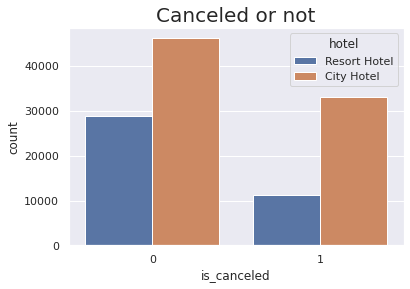

In [229]:
sns.set(style = "darkgrid")
plt.title("Canceled or not", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "is_canceled", hue = 'hotel', data = df)

<AxesSubplot:xlabel='hotel', ylabel='arrival_date_week_number'>

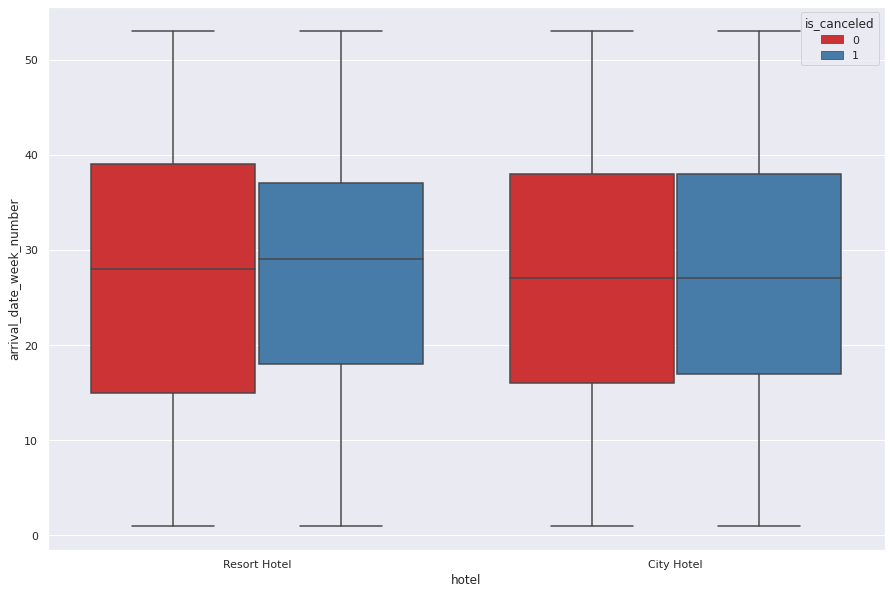

In [230]:
plt.figure(figsize=(15,10))
sns.boxplot(y="arrival_date_week_number", x="hotel", data=df, hue="is_canceled", palette='Set1')

### Heatmap de corrélation

La heatmap de corrélation permet de représenter la corrélation pour chaque paire de colonnes à l'aide d'un code couleur.
On observe ici aucune corrélation particulière entre les données.

<AxesSubplot:>

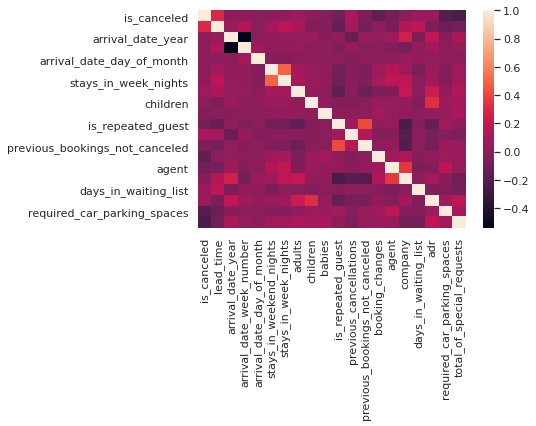

In [231]:
corr = df.corr()
sns.heatmap(corr)

In [232]:
# Un échantillon des données présentes dans le DataFrame
df.sample(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
44244,City Hotel,0,164,2015,October,40,2,0,2,1,...,No Deposit,19.0,NaN,0,Transient-Party,100.00,0,0,Check-Out,2015-10-04
23291,Resort Hotel,0,82,2016,April,16,16,2,3,2,...,No Deposit,241.0,NaN,0,Transient,73.76,1,1,Check-Out,2016-04-21
42520,City Hotel,0,55,2015,September,37,6,2,0,2,...,No Deposit,1.0,NaN,0,Transient-Party,75.00,0,0,Check-Out,2015-09-08
90941,City Hotel,0,11,2016,June,25,13,1,0,1,...,No Deposit,10.0,NaN,0,Transient,83.00,0,0,Check-Out,2016-06-14
64779,City Hotel,1,615,2017,March,11,16,0,2,2,...,Non Refund,1.0,NaN,0,Transient,62.00,0,0,Canceled,2015-10-21
30114,Resort Hotel,0,4,2016,November,47,14,1,0,1,...,No Deposit,240.0,NaN,0,Transient,43.00,0,2,Check-Out,2016-11-15
83278,City Hotel,0,53,2016,January,5,24,2,1,2,...,No Deposit,28.0,NaN,0,Transient,60.00,0,1,Check-Out,2016-01-27
89752,City Hotel,0,119,2016,May,22,23,1,2,1,...,No Deposit,37.0,NaN,0,Transient-Party,90.00,0,1,Check-Out,2016-05-26
4739,Resort Hotel,0,169,2016,March,14,31,0,3,2,...,Refundable,NaN,223.0,0,Transient-Party,66.00,0,0,Check-Out,2016-04-03
116464,City Hotel,0,191,2017,July,29,17,1,3,3,...,No Deposit,9.0,NaN,0,Transient,147.90,0,1,Check-Out,2017-07-21


### Gestion des NA
Affichage de la somme des valeurs nulles pour chaque colonnes

In [233]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Calcul du ratio de valeurs nulles pour chaque colonnes

In [234]:
ratio_company = (df['company'].isna().sum() / len(df)) * 100
ratio_agent = (df['agent'].isna().sum() / len(df)) * 100
ratio_country = (df['country'].isna().sum() / len(df)) * 100

print("Company null ratio : " + str(ratio_company) + "\n" +
      "Agent null ratio : " + str(ratio_agent) + "\n" +
      "Country null ratio : " + str(ratio_country))

Company null ratio : 94.30689337465449
Agent null ratio : 13.686238378423655
Country null ratio : 0.40874445095904177


On observe que les colonnes company et agent ont un pourcentage important de valeurs nulles, c'est pourquoi
nous allons les retirer du dataset

In [235]:
df = df.drop(columns=['company', 'agent'])

On élimine ensuite les lignes contenant des valeurs nulles

In [236]:
df = df.dropna()
df.shape

(118898, 30)

On revérifie la présence de valeurs nulles dans le DataFrame. On voit qu'il n'en reste aucune

In [237]:
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  object 
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  object 
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  meal            

### Transformation des variables catégoriques en variables quantitatives

In [239]:
# Conversion grâce à la méthode astype()
df['arrival_date_month'] = df['arrival_date_month'].astype('category').cat.codes

In [240]:
# Utilisation d'un LabelEncoder

le = LE()
df['hotel'] = le.fit_transform(df['hotel'])
df['country'] = le.fit_transform(df['country'])
df['market_segment'] = le.fit_transform(df['market_segment'])
df['distribution_channel'] = le.fit_transform(df['distribution_channel'])
df['reserved_room_type'] = le.fit_transform(df['reserved_room_type'])
df['assigned_room_type'] = le.fit_transform(df['assigned_room_type'])
df['deposit_type'] = le.fit_transform(df['deposit_type'])
df['customer_type'] = le.fit_transform(df['customer_type'])
df['reservation_status'] = le.fit_transform(df['reservation_status'])
df['reservation_status_date'] = le.fit_transform(df['reservation_status_date'])

In [241]:
# Suppression de la colonne meal car non-pertinente pour l'objectif voulu
df = df.drop(columns=['meal'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  int64  
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  int8   
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  country         

Observation de la corrélation des colonnes par rapport à is_canceled

In [242]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

reservation_status                0.917223
deposit_type                      0.468497
lead_time                         0.291994
country                           0.270225
total_of_special_requests         0.235643
required_car_parking_spaces       0.194796
assigned_room_type                0.175880
distribution_channel              0.165539
reservation_status_date           0.162965
booking_changes                   0.144659
hotel                             0.133964
previous_cancellations            0.109922
is_repeated_guest                 0.085179
customer_type                     0.068768
reserved_room_type                0.062230
adults                            0.058381
market_segment                    0.056948
previous_bookings_not_canceled    0.055493
days_in_waiting_list              0.054016
adr                               0.046199
babies                            0.032521
stays_in_week_nights              0.024110
arrival_date_year                 0.016412
arrival_dat

### Séparation features/target

In [243]:
y = df['is_canceled']
x = df.drop(columns=['is_canceled'])

On sépare nos données d'entrainement et de test avec la fonction train_test_split()

In [244]:
splits = train_test_split(x, y, random_state=3, stratify=y)
x_tr, x_te, y_tr, y_te = splits

In [245]:
# Vérification de la correspondance des dimension
for each in [x_tr, x_te, y_tr, y_te]:
    print(each.shape)

(89173, 28)
(29725, 28)
(89173,)
(29725,)


### Pipeline
Création d'une pipeline et d'une GridSearchCV afin de trouver la meilleures accuracy parmis plusieurs algorithme et
plusieurs jeux d'hyperparamètres

In [246]:
pipeline_details = [('pca', PCA()),
                    ('knn', KNN())]

pipeline_svc = [('svc', SVC())]

pipeline = Pipeline(pipeline_details)

In [247]:
hp_parameters = {'knn__n_neighbors': [1, 3, 5, 9, 21]}
hp_parameters_svc = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [248]:
hp_search = GridSearchCV(pipeline,
                         hp_parameters,
                         scoring='accuracy',
                         cv=5)
hp_search.fit(x_tr, y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 9, 21]},
             scoring='accuracy')

In [249]:
# Not working
# hp_search_svc = GridSearchCV(SVC(), hp_parameters_svc, scoring='accuracy', cv=5)
# hp_search_svc.fit(x_tr, y_tr)

In [250]:
# Affichage du meilleur score trouvé
hp_search.best_score_


0.9005528642665048

In [251]:
# Affichage de meilleurs paramètres et algo
hp_search.best_params_


{'knn__n_neighbors': 1}

In [252]:
# hp_search_svc.best_score_

Le résultat de la GridSearchCV nous indique que l'algorithme KNN avec l'hyperparamètre n_neighbors à 1

### Réajustement des features
Un peu de feature feature engineering pour essayer d'améliorer le score d'accuracy

In [253]:
# Regroupemement des features stays_in_weekend_nights et feature engineering
total_nights = df["stays_in_weekend_nights"]+ df["stays_in_week_nights"]

df['total_nights'] = total_nights
# Regroupement des features adults, children et babies
total_people = df['adults'] + df['children'] + df['babies']
df['total_people'] = total_people

In [254]:
# On supprime les colonnes qui ont servi aux regroupements
df = df.drop(columns=['adults', 'babies', 'children', 'stays_in_week_nights', 'stays_in_weekend_nights', 'deposit_type'])

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  int64  
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  int8   
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   country                         118898 non-null  int64  
 8   market_segment                  118898 non-null  int64  
 9   distribution_channel            118898 non-null  int64  
 10  is_repeated_guest               118898 non-null  int64  
 11  previous_cancellations          118898 non-null  int64  
 12  previous_booking

<AxesSubplot:>

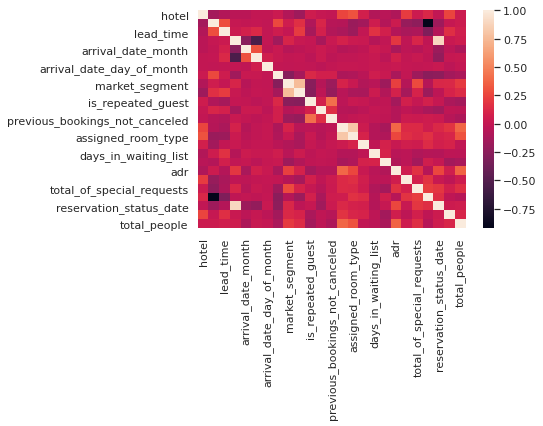

In [256]:
# Revérification de la heatmap de corrélation, on n'observe toujours pas de corrélation particulière
new_corr = df.corr()
sns.heatmap(new_corr)

In [257]:
new_cancel_corr = df.corr()["is_canceled"]
new_cancel_corr.abs().sort_values(ascending=False)[1:]

reservation_status                0.917223
lead_time                         0.291994
country                           0.270225
total_of_special_requests         0.235643
required_car_parking_spaces       0.194796
assigned_room_type                0.175880
distribution_channel              0.165539
reservation_status_date           0.162965
booking_changes                   0.144659
hotel                             0.133964
previous_cancellations            0.109922
is_repeated_guest                 0.085179
customer_type                     0.068768
reserved_room_type                0.062230
market_segment                    0.056948
previous_bookings_not_canceled    0.055493
days_in_waiting_list              0.054016
adr                               0.046199
total_people                      0.045031
total_nights                      0.016971
arrival_date_year                 0.016412
arrival_date_week_number          0.007465
arrival_date_day_of_month         0.006127
arrival_dat

In [258]:
df = df.drop(columns=['lead_time', 'country'])

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  int64  
 1   is_canceled                     118898 non-null  int64  
 2   arrival_date_year               118898 non-null  int64  
 3   arrival_date_month              118898 non-null  int8   
 4   arrival_date_week_number        118898 non-null  int64  
 5   arrival_date_day_of_month       118898 non-null  int64  
 6   market_segment                  118898 non-null  int64  
 7   distribution_channel            118898 non-null  int64  
 8   is_repeated_guest               118898 non-null  int64  
 9   previous_cancellations          118898 non-null  int64  
 10  previous_bookings_not_canceled  118898 non-null  int64  
 11  reserved_room_type              118898 non-null  int64  
 12  assigned_room_ty

### Tests des modèles avec les nouvelles features

In [260]:
y = df['is_canceled']
x = df.drop(columns=['is_canceled'])

In [261]:
x_tr, x_te, y_tr, y_te = train_test_split(x, y, random_state=3, stratify=y, train_size=0.8)

In [262]:
pipeline_details = [('pca', PCA()),
                    ('knn', KNN())]

In [263]:
pipeline = Pipeline(pipeline_details)

In [264]:
hp_parameters = {'knn__n_neighbors': [1, 3, 5, 9, 21]}

In [265]:
hp_search = GridSearchCV(pipeline,
                         hp_parameters,
                         scoring='accuracy',
                         cv=5)
hp_search.fit(x_tr, y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 9, 21]},
             scoring='accuracy')

In [266]:
hp_search.best_score_


0.9602914494591491

In [267]:
hp_search.best_params_

{'knn__n_neighbors': 1}

On peut voir qu'avec les nouvelles features le score d'accuracy est passé de 90% à 96%

### Construction du modèle

In [268]:
def get_accuracy(preds, target):
    m = target.shape[0] # nombre d'exemples
    total_correct = (preds == target).sum()
    accuracy = total_correct / m
    return str(round(accuracy * 100, 2)) + "%"

In [269]:
knn = KNN(n_neighbors=1)

In [270]:
knn.fit(x_tr, y_tr)

KNeighborsClassifier(n_neighbors=1)

In [271]:
preds = knn.predict(x_te)

In [272]:
get_accuracy(preds, y_te)

'96.47%'

### Création d'un PCA

In [273]:
pca = PCA()
pca.fit(x_tr)

PCA()

In [274]:
x_tr_pca = pca.transform(x_tr)
x_te_pca = pca.transform(x_te)

/home/vincent/.local/share/virtualenvs/ML-Hotel-booking-6ZvzLYAR/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Graphe pour choisir le nombre de PC')

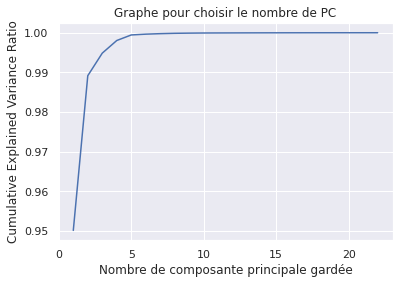

In [275]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot([i for i in range(1, len(cumsum) + 1)], cumsum)
plt.xlabel('Nombre de composante principale gardée')
plt.ylabel('Cumulative Explained Variance Ratio') # Ratio d'Informations (==variance) Conservees
plt.title('Graphe pour choisir le nombre de PC')

In [276]:
pca = PCA(n_components=5)
pca.fit(x_tr)
x_tr_PCA = pca.transform(x_tr)
x_te_PCA = pca.transform(x_te)

In [277]:
knn = KNN(n_neighbors=1)
knn.fit(x_tr_PCA, y_tr)

KNeighborsClassifier(n_neighbors=1)

In [278]:
preds = knn.predict(x_te_PCA)
get_accuracy(preds, y_te)

'96.1%'

### Confusion matrix

In [279]:
knn.fit(x_tr, y_tr)

KNeighborsClassifier(n_neighbors=1)

In [280]:
def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

In [281]:
y_preds = knn.predict(x_te)
y_preds.shape

(23780,)

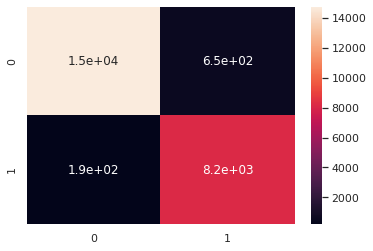

Accuracy : 0.9646761984861227


In [282]:
cm_train = confusion_matrix(y_preds, y_te, labels=[0,1])
show_cm(cm_train, [0,1])
#Accuracy du training
accuracy = lambda p, y : (p==y).sum()/len(y)
print('Accuracy : {}'.format(accuracy(y_preds, y_te)))

### ROC / AUC

In [298]:
proba = knn.predict_proba(x_tr)
proba1 = knn.predict_proba(x_te)
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

In [312]:
try:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_te, proba1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
except ValueError as err:
    print(err)

In [313]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), proba1[:, i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [314]:
plt.figure()
lw = 2

<Figure size 432x288 with 0 Axes>

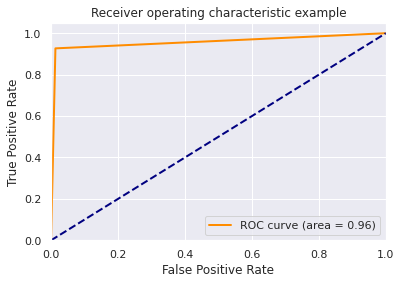

In [315]:
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [304]:
try:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_tr, proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
except ValueError as err:
    print(err)

In [305]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_tr.ravel(), proba[:, i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

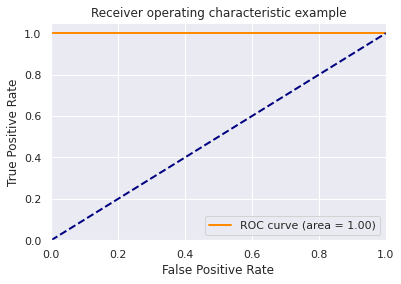

In [306]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()